<a href="https://colab.research.google.com/github/GeorgeCrossIV/product-image-search/blob/main/Product_Image_Similarity_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Image Similarity Search
The purpose of this notebook is to demonstrate searching a product catalog by uploading an image and finding similar products.

In [ ]:
# Install libraries
!pip install kaggle torch cassandra-driver sentence-transformers matplotlib

In [2]:
# Global settings
process_data = False  # set to True to reset the data and generate the vectors
use_keys = True # set to False if you'd like to be prompted for key variables

In [76]:
# Imports

# Standard libraries for file operations, time tracking, and secure user input
import os
import time
import getpass

# Google Colab specific utilities
from google.colab import userdata
from google.colab import files

# For working with JSON files
import json
import csv

# Utilities for working with compressed files
import zipfile

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# embeddings
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel, tokenization_utils
import torch

# Cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import SimpleStatement

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [48]:
# Variables

# Kaggle data load
kaggle_token = userdata.get('kaggle_key') if use_keys else getpass.getpass("Enter your kaggle token/key: ")
kaggle_username = userdata.get('kaggle_username') if use_keys else input("Enter your username: ")

# Load the CLIP model
img_model = SentenceTransformer('clip-ViT-B-32')

# Load pretrained MiniLM model and tokenizer
text_model='sentence-transformers/all-MiniLM-L6-v2'
token = userdata.get("huggingface_token") # hugging face token
tokenizer = AutoTokenizer.from_pretrained(text_model, token=token)
text_model = AutoModel.from_pretrained(text_model, token=token)

In [32]:
TABLE_NAME = 'products'
ASTRA_DB_KEYSPACE = 'images'

In [7]:
# Ensure the directory exists before writing the file
os.makedirs('/root/.kaggle', exist_ok=True)
os.makedirs('/content/logs', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as fp:
    fp.write(json.dumps({"username":f"{kaggle_username}","key":f"{kaggle_token}"}))

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): copyright-authors
 99% 557M/565M [00:06<00:00, 96.1MB/s]
100% 565M/565M [00:06<00:00, 89.3MB/s]


In [9]:
zip_path = '/content/fashion-product-images-small.zip'
extract_to_dir = '/content/products'  # Specify the directory to extract to

# Ensure the extraction directory exists
os.makedirs(extract_to_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f'Files extracted to {extract_to_dir}')

Files extracted to /content/products


In [16]:
# Preprocess the CSV to handle irregular lines
cleaned_rows = []
with open('/content/products/styles.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    cleaned_rows.append(header)

    for row in reader:
        if len(row) == len(header):
            cleaned_rows.append(row)

# Write the cleaned data to a new CSV file
with open('/content/products/cleaned_styles.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(cleaned_rows)

# Read the cleaned CSV
df = pd.read_csv('/content/products/cleaned_styles.csv')

In [ ]:
# Prepare dataset
df = pd.read_csv('/content/products/cleaned_styles.csv')

# Add the image path based on the id field
df['image_path'] = df['id'].apply(lambda x: os.path.join('products/images', f"{x}.jpg"))

# Filter out rows where the image file does not exist
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]

# Display the first few rows
df.head()



In [97]:
# Functions
def get_image_embedding(image_path):
    #image = Image.open(image_path).convert("RGB")
    image_emb = img_model.encode(Image.open(image_path))
    #inputs = processor(images=image, return_tensors="pt")
    #outputs = model.get_image_features(**inputs)
    return image_emb.tolist()

def get_text_embedding(text):
    # Tokenize input text
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Get model output
    with torch.no_grad():
        outputs = text_model(**inputs)

    # Get the embeddings from the last hidden state
    # You might also consider using pooled output for sentence-level embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1)

    # Convert the tensor embeddings into a flat list of floats
    float_embeddings = embeddings.numpy().flatten().tolist()

    return float_embeddings

def search_similar_image(image_path, k=5):
  image_embedding = get_image_embedding(image_path)
  query = f"""
  SELECT masterCategory, productDisplayName, subCategory, image_embedding, text_embedding, image_path
  FROM {ASTRA_DB_KEYSPACE}.{TABLE_NAME}
  ORDER BY image_embedding ANN OF %s LIMIT %s;
  """
  results = session.execute(query, (image_embedding, k))
  return results

def get_most_similar_image(image_path):
  return search_similar_image(image_path, 1)

def display_image(image_path):
    plt.title(image_path)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.show()


In [93]:
# Generate embeddings
df = df.head(10)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path,image_embedding,text_embedding
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,products/images/15970.jpg,"[0.046916257590055466, 0.2546752095222473, -0....","[-0.39892444014549255, 0.5682668685913086, 0.0..."
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,products/images/39386.jpg,"[0.07135900110006332, -0.07549282908439636, -0...","[-0.3941445052623749, 0.07854604721069336, 0.0..."
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,products/images/59263.jpg,"[-0.14727634191513062, 0.04621269553899765, 0....","[-0.9665471315383911, -0.24780318140983582, -0..."
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,products/images/21379.jpg,"[-0.03485475480556488, 0.09414006769657135, -0...","[-0.34499526023864746, -0.12704508006572723, -..."
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,products/images/53759.jpg,"[-0.46638545393943787, 0.29436105489730835, -0...","[-0.516461193561554, 0.3104739189147949, -0.23..."


In [26]:
# Astra variables
ASTRA_DB_TOKEN_BASED_PASSWORD = userdata.get('ASTRA_DB_TOKEN_BASED_PASSWORD')  if use_keys else getpass.getpass(prompt="Enter your AstraDB token: ")

Your Astra DB Keyspace name (e.g. imagevecs): images


In [27]:
# Get the Secure Connect Bundle
print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    scb_path = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-cassio-db.zip to secure-connect-cassio-db.zip


In [31]:
# Connect to Astra
SECURE_CONNECT_BUNDLE_PATH = scb_path
ASTRA_CLIENT_ID = 'token'
ASTRA_CLIENT_SECRET = ASTRA_DB_TOKEN_BASED_PASSWORD
KEYSPACE_NAME = ASTRA_DB_KEYSPACE

cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

In [78]:
# Create the table
session.execute(f"""
CREATE TABLE IF NOT EXISTS {ASTRA_DB_KEYSPACE}.{TABLE_NAME} (
    id INT PRIMARY KEY,
    image_embedding VECTOR<float, 512>,
    text_embedding VECTOR<float, 384>,
    masterCategory TEXT,
    productDisplayName TEXT,
    subCategory TEXT,
    image_path TEXT
);
""")

print(f"Creating index image_ann_index on table {TABLE_NAME} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS image_ann_index ON {KEYSPACE_NAME}.{TABLE_NAME}(image_embedding) USING 'StorageAttachedIndex'")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS text_ann_index ON {KEYSPACE_NAME}.{TABLE_NAME}(text_embedding) USING 'StorageAttachedIndex'")

print(f"Truncate table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"TRUNCATE TABLE {KEYSPACE_NAME}.{TABLE_NAME}")


Creating index image_ann_index on table products and inserting example data
Truncate table products in keyspace images


In [79]:
# Insert data into the table
for _, row in df.iterrows():
    image_embedding = get_image_embedding(row['image_path'])
    text_embedding = get_text_embedding(f"{row['id']} {row['productDisplayName']}")
    query = SimpleStatement(
        f"""
        INSERT INTO {ASTRA_DB_KEYSPACE}.{TABLE_NAME} (id, image_embedding, text_embedding, masterCategory, productDisplayName, subCategory, image_path)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        """
    )

    session.execute(query, (row['id'], image_embedding, text_embedding, row['masterCategory'], row['productDisplayName'], row['subCategory'], row['image_path']))


In [80]:
# Test the search function
results = get_most_similar_image('products/images/10000.jpg')
for row in results:
    print(f"Product Display Name: {row.productdisplayname}, SubCategory: {row.subcategory}")

Product Display Name: Puma Men Pack of 3 Socks, SubCategory: Socks


Original image
	Turtle Check Men Navy Blue Shirt


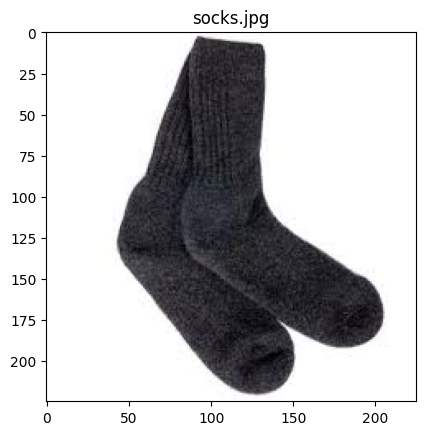

	Puma Men Pack of 3 Socks


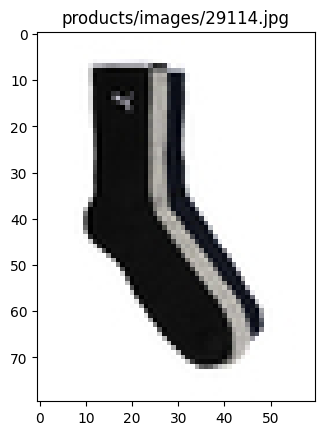

In [96]:
# Find socks in the catalog
image_path = 'socks.jpg'
print('Original image')
display_image(image_path)

results = get_most_similar_image(image_path)
for row in results:
  print(row.productdisplayname)
  display_image(row.image_path)

Original image


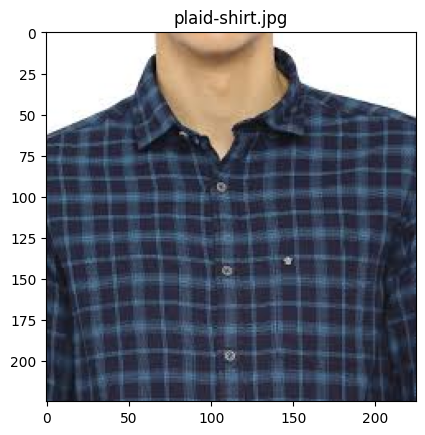

Turtle Check Men Navy Blue Shirt


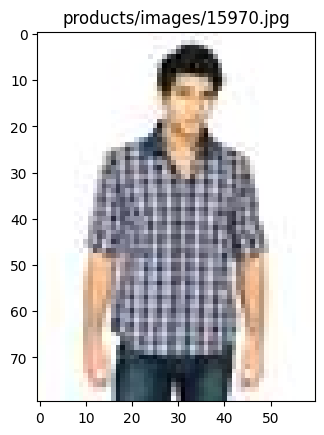

In [98]:
image_path = 'plaid-shirt.jpg'
print('Original image')
display_image(image_path)

results = get_most_similar_image(image_path)
for row in results:
  print(row.productdisplayname)
  display_image(row.image_path)